In [18]:
import warnings
warnings.filterwarnings("ignore")
import nltk
import numpy as np 
import pandas as pd
import regex as re
import tensorflow
from tensorflow import keras
from nltk.corpus import stopwords
from keras.layers import Embedding
from keras import Sequential, Input
from nltk.stem.porter import PorterStemmer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import LSTM, Dense



In [19]:
submit = "dataset/submit.csv"
test = "dataset/test.csv"

In [20]:
df = pd.read_csv(test, sep=',')
df.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [21]:
X = df.copy()
y =  pd.read_csv(submit, sep=',')
new_df = pd.merge(X, y, how='left', on='id')

In [22]:
new_df.isnull().sum()

id          0
title     122
author    503
text        7
label       0
dtype: int64

In [48]:
new_df.head()
new_df.dropna(inplace=True)


In [59]:
X = new_df.drop(['label'], axis = 1)
y = new_df['label']

In [60]:
new_df.shape

(4575, 5)

#  Text preprocessing

In [62]:
type(X['title'][0])

str

In [65]:
ps = PorterStemmer()
corpus = []
for i in range(0, len(X)):
    review = re.sub('[^a-zA-Z]', ' ',  str(X['title'].iloc[i]))
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [66]:
corpus[:3]

['specter trump loosen tongu purs string silicon valley new york time',
 'nodapl nativ american leader vow stay winter file lawsuit polic',
 'tim tebow attempt anoth comeback time basebal new york time']

In [67]:
# OHE 
tokenize  = Tokenizer()
tokenize.fit_on_texts(corpus)

OHE_representation = tokenize.texts_to_sequences(corpus)

# Padding 

padded = tensorflow.keras.utils.pad_sequences(
    OHE_representation,
    maxlen=8,
    dtype='int32',
    padding='pre',
    truncating='pre',
    value=0.0
)

In [68]:
all_words = []

for  sentence in corpus:
    words =  nltk.tokenize.word_tokenize(sentence) 
    all_words.extend(words)
    
tokens_size = len(set(all_words))
    

In [69]:
input = Input(shape=(8,))
Embeddding = Embedding(input_dim=tokens_size, output_dim=10)
lstm = LSTM(100)

In [70]:
model  = Sequential()

model.add(input)
model.add(Embeddding)
model.add(lstm)
output = model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 8, 10)          │        73,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        44,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,791 (460.12 KB)

 Trainable params: 117,791 (460.12 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
# split Data
from  sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(np.array(padded), np.array(y), test_size=0.33, random_state=1)

#  Model Training 

In [73]:
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6201 - loss: 0.6490 - val_accuracy: 0.7593 - val_loss: 0.5523
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7864 - loss: 0.4518 - val_accuracy: 0.7483 - val_loss: 0.5410
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8463 - loss: 0.3535 - val_accuracy: 0.7133 - val_loss: 0.6094
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9260 - loss: 0.2146 - val_accuracy: 0.6976 - val_loss: 0.8233
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9601 - loss: 0.1287 - val_accuracy: 0.6632 - val_loss: 1.0090
Epoch 6/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9681 - loss: 0.0955 - val_accuracy: 0.6754 - val_loss: 1.3000
Epoch 7/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9793 - loss: 0.0743 - val_accuracy: 0.6812 - val_loss: 1.1426
Epoch 8/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9826 - loss: 0.0626 - val_accuracy: 0.

In [80]:
y_pred = (model.predict(X_test) > 0.5).astype(dtype='int8')


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [81]:
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_test, y_pred)

In [36]:
# Plot non-normalized confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'matplotlib'

In [90]:
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


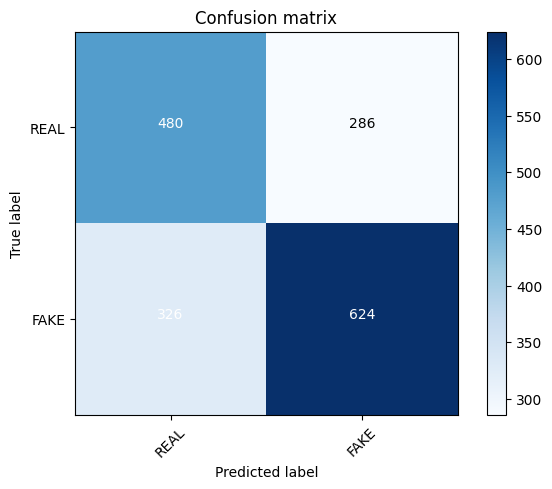

In [91]:
plot_confusion_matrix(cm, classes= ['REAL','FAKE'] )

In [92]:
cm.shape

(2, 2)

In [95]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.6433566433566433

In [97]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.63      0.61       766
           1       0.69      0.66      0.67       950

    accuracy                           0.64      1716
   macro avg       0.64      0.64      0.64      1716
weighted avg       0.65      0.64      0.64      1716

